# Projeto 3

<b>Tema:</b> Estimar o retorno financeiro de um filme

<b>Técnica:</b> Regressão Linear

<b>Grupo:</b> Lucas Leal Vale, Matheus Augusto Soares, Rafael Almada
___

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

___
## _Introdução_

Neste projeto, o objetivo final do grupo, é conseguir estimar com certa precisão o retorno financeiro de um filme hipotético X dado algumas características do mesmo. Para isso estamos utilizando uma base de dados que pode ser encontrada no link abaixo:

Link do DataSet: https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv

In [2]:
#Limpando DataFrame
movies=pd.read_csv('movies_metadata.csv', low_memory=False)
df=movies.loc[:, {'id','original_title','original_language','genres','popularity','runtime','budget','revenue',
                 'production_companies','production_countries', 'release_date','vote_average',}]
df.head(3)

,original_title,vote_average,genres,budget,production_countries,revenue,production_companies,id,original_language,release_date,runtime,popularity
0,Toy Story,7.7,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",30000000,"[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]",862,en,1995-10-30,81.0,21.946943
1,Jumanji,6.9,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",65000000,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",8844,en,1995-12-15,104.0,17.015539
2,Grumpier Old Men,6.5,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602,en,1995-12-22,101.0,11.7129


In [3]:
# Tirando valores de budget que estavam como arquivos de imagens e não números
df=df.drop([19730, 29503, 35587])

# Colocando algumas colunas como float para analisá-las quantitativamente
df['budget']=df['budget'].astype('float64')
df['popularity']=df['popularity'].astype('float64')
df['id']=df['id'].astype('float64')
df.dtypes

original_title           object
vote_average            float64
genres                   object
budget                  float64
production_countries     object
revenue                 float64
production_companies     object
id                      float64
original_language        object
release_date             object
runtime                 float64
popularity              float64
dtype: object

In [4]:
#Ordenando em ordem crescente de acordo com o id, e filtrando valores 0 das variáveis float
df=df[(df['revenue']>0) & (df['budget']>0)  & (df['runtime']>0)]
df=df.sort_values(['id'], ascending=[True])
df['id']=df['id'].astype('int')

df=df.set_index('id')

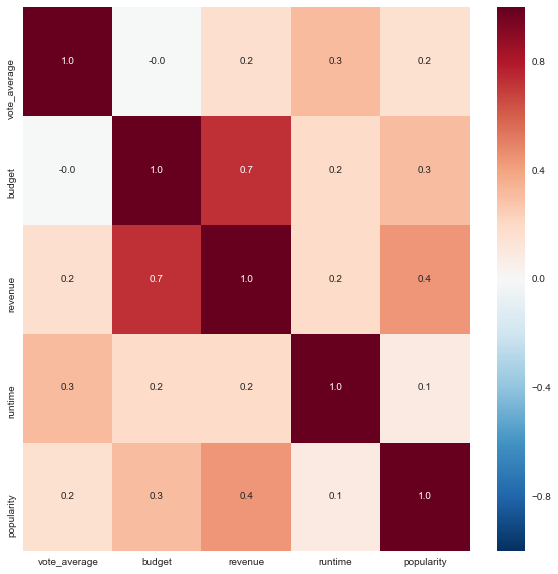

In [5]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot = True,fmt='.1f')

Com o gráfico acima obtemos os resultados das correlações entre cada coluna (variável). Como queremos achar uma forma de estimar o retorno financeiro de um filme ao final do projeto, precisamos analisar as variáveis em relação à variável 'Revenue'. Dessa forma percebemos que, em nossa regressão, quanto maior a correlação de uma variável X em relação à nossa variável fixada (revenue), quanto mais próxima a 1, seja positiva ou negativamente, mais importante será na nossa regressão tal variável.

Logo, das variáveis escolhidas até o momento, podemos dizer que em ordem de maior relevância no cálculo da nossa regressão estão em ordem decrescente, primeiro Budget (ou custo de produção do filme), o qual era esperado ter grande impacto no retorno do mesmo. Logo em seguida vem Popularity ou a popularidade do filme (quanto falam dele). Depois, juntos, seguem as variáveis Runtime (Tempo corrido em tela do filme) e Vote Average (Nota do filme dada pela comunidade).